### Homework 4 Appendix

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from ISLP import load_data
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage
from sklearn.metrics import confusion_matrix
np.random.seed(2)
import seaborn as sns

### 1.0 Load and Process Dataset

In [2]:
# Load the dataset
phishingurl_data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

In [6]:
phishingurl_data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


### 1.1 Check for Missing Values

In [7]:
phishingurl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

There appears to be no missing values in the dataset.  We believe this is because the URLs were gathered by a program and if an item wasn't present on the website, like a password field, the program appropriately labeled it as a 0.

### 1.2 Check the Mean and Variance for Scaling

In [8]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 5000 records
url_sample = phishingurl_data.sample(5000, random_state=13)

# Set index equal to the domain field
url_sample.set_index('Domain', inplace=True)

# Drop text fields: Filename, URL, TLD, Title
url_sample_data = url_sample.drop(['FILENAME', 'URL', 'TLD', 'Title'],axis = 1)

In [6]:
url_sample_data.head()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
Domain,,,,,,,,,,,,,,,,,,,,,
www.comercustombuilders.com,34,27,0,100.000000,1.0,0.522907,0.063880,3,1,0,...,1,0,0,23,4,16,18,0,13,1
www.marvell.com,22,15,0,100.000000,1.0,0.522907,0.062975,3,1,0,...,0,0,1,32,7,10,142,0,18,1
www.globalstatupdate.com,31,24,0,75.642857,1.0,0.522907,0.058841,3,1,0,...,0,0,0,0,0,0,0,0,0,0
www.snoeps.nl,20,13,0,100.000000,1.0,0.008200,0.063324,2,1,0,...,1,1,1,14,5,12,19,2,22,1
papainoelexiste.com,87,19,0,15.266204,1.0,0.522907,0.030750,3,0,0,...,1,0,1,1,1,0,1,0,1,0


In [7]:
# Check the Mean
url_sample_data.mean()

URLLength                        34.165200
DomainLength                     21.242800
IsDomainIP                        0.003600
URLSimilarityIndex               78.814404
CharContinuationRate              0.847829
TLDLegitimateProb                 0.257006
URLCharProb                       0.055631
TLDLength                         2.768600
NoOfSubDomain                     1.153800
HasObfuscation                    0.001200
NoOfObfuscatedChar                0.008400
ObfuscationRatio                  0.000087
NoOfLettersInURL                 19.100800
LetterRatioInURL                  0.513347
NoOfDegitsInURL                   1.847600
DegitRatioInURL                   0.028853
NoOfEqualsInURL                   0.057600
NoOfQMarkInURL                    0.026800
NoOfAmpersandInURL                0.028200
NoOfOtherSpecialCharsInURL        2.285800
SpacialCharRatioInURL             0.062861
IsHTTPS                           0.790000
LineOfCode                     1083.973000
LargestLine

In [8]:
# Check the Variance
url_sample_data.var()

URLLength                     9.639991e+02
DomainLength                  7.859637e+01
IsDomainIP                    3.587758e-03
URLSimilarityIndex            8.305884e+02
CharContinuationRate          4.683432e-02
TLDLegitimateProb             6.303754e-02
URLCharProb                   1.178379e-04
TLDLength                     3.595259e-01
NoOfSubDomain                 3.402136e-01
HasObfuscation                1.198800e-03
NoOfObfuscatedChar            7.554455e-02
ObfuscationRatio              7.249281e-06
NoOfLettersInURL              5.054029e+02
LetterRatioInURL              1.549070e-02
NoOfDegitsInURL               5.503058e+01
DegitRatioInURL               5.150852e-03
NoOfEqualsInURL               3.083439e-01
NoOfQMarkInURL                3.488874e-02
NoOfAmpersandInURL            3.862820e-01
NoOfOtherSpecialCharsInURL    7.612841e+00
SpacialCharRatioInURL         1.007368e-03
IsHTTPS                       1.659332e-01
LineOfCode                    4.996780e+06
LargestLine

The columns for lines of code and largest line length are very high compared to the other variables.  We should scale this data before performing PCA, SVD, or Kmeans on it.

### 1.3 Scaling the Data

In [11]:
# Drop true / false values
X = url_sample_data.drop(['HasObfuscation', 
                          'IsHTTPS',
                          'IsDomainIP', 
                          'HasTitle',
                          'HasFavicon', 
                          'Robots',
                          'IsResponsive',
                          'HasDescription',
                          'HasExternalFormSubmit', 
                          'HasSocialNet', 
                          'HasSubmitButton', 
                          'HasHiddenFields', 
                          'HasPasswordField', 
                          'Bank',
                          'Pay',
                          'Crypto',
                          'HasCopyrightInfo',
                          'label'],axis = 1)

# Scale the dataset
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

In [10]:
X_scaled.head()

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.comercustombuilders.com,-0.005321,0.649462,0.735176,0.703224,1.059164,0.759941,0.385959,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,0.268683,-0.047106,-0.187059,0.227526,-0.310491,-0.205827,-0.276248
www.marvell.com,-0.391854,-0.704242,0.735176,0.703224,1.059164,0.676517,0.385959,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,0.073561,0.090345,0.084146,-0.027481,0.507636,-0.205827,-0.238319
www.globalstatupdate.com,-0.101954,0.311036,-0.110058,0.703224,1.059164,0.295704,0.385959,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,-0.316683,-0.398370,-0.548666,-0.452494,-0.429252,-0.205827,-0.374861
www.snoeps.nl,-0.456276,-0.929859,0.735176,0.703224,-0.991071,0.708708,-1.281972,-0.263708,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,0.073561,-0.184557,-0.096658,0.057521,-0.303893,-0.019000,-0.207977
papainoelexiste.com,1.701865,-0.253007,-2.205229,0.703224,1.059164,-2.292355,0.385959,-1.978327,-0.030565,-0.032316,...,-0.403138,-0.205185,-0.084432,-0.316683,-0.383098,-0.458264,-0.452494,-0.422654,-0.205827,-0.367276


### 2.0 PCA

In [11]:
# Perform PCA
pca = PCA()
pca_out = pca.fit_transform(X_scaled)

### 2.1 PCA Principal Components

In [12]:
pd.DataFrame({'Center': scaler.mean_
                   , 'Scale': scaler.scale_}
                  , index=X_scaled.columns)

,Center,Scale
URLLength,34.165200,31.045230
DomainLength,21.242800,8.864573
URLSimilarityIndex,78.814404,28.817049
CharContinuationRate,0.847829,0.216391
TLDLegitimateProb,0.257006,0.251048
URLCharProb,0.055631,0.010854
TLDLength,2.768600,0.599545
NoOfSubDomain,1.153800,0.583220
NoOfObfuscatedChar,0.008400,0.274826
ObfuscationRatio,0.000087,0.002692


In [13]:
print("Number of Principal Components:", pca.n_components_)

Number of Principal Components: 33


(0.0, 1.03)

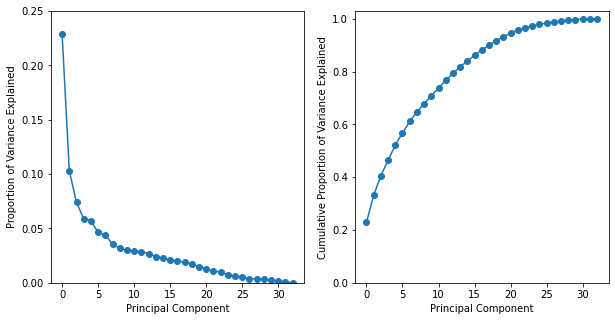

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot of proportion of variance explained
ax[0].plot(pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[0].set_ylim(0, 0.25)

# Plot of cumulative proportion of variance explained
ax[1].plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cumulative Proportion of Variance Explained')
ax[1].set_ylim(0, 1.03)

In [15]:
pc2_df = pd.DataFrame(pca.components_[:2].T,
            index=X_scaled.columns,
            columns=['PC1', 'PC2'])

# Top 5 PC1 variables
top_5_pc1 = pc2_df.loc[pc2_df['PC1'].abs().sort_values(ascending=False).index].head(5)
# Top 5 PC2 variables 
top_5_pc2 = pc2_df.loc[pc2_df['PC2'].abs().sort_values(ascending=False).index].head(5)

In [16]:
print(top_5_pc1)
print(top_5_pc2)

                                 PC1       PC2
NoOfOtherSpecialCharsInURL  0.315503  0.147167
URLSimilarityIndex         -0.302952  0.098889
URLLength                   0.288370  0.290611
NoOfLettersInURL            0.280379  0.268653
NoOfDegitsInURL             0.260896  0.246804
                         PC1       PC2
NoOfEqualsInURL     0.208267  0.340564
URLLength           0.288370  0.290611
NoOfLettersInURL    0.280379  0.268653
NoOfQMarkInURL      0.195214  0.255383
NoOfAmpersandInURL  0.126598  0.253680


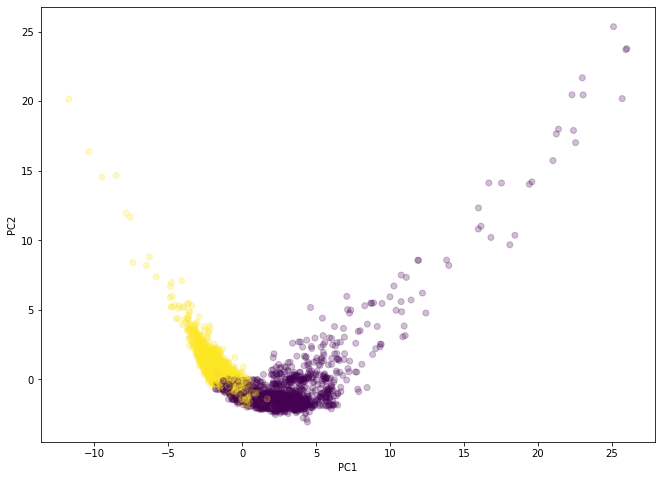

In [17]:
fig , ax = plt.subplots(figsize=(11,8))

ax.scatter(pca_out[:,0], pca_out[:,1], alpha=0.25, c=url_sample_data['label'])

ax.set_xlabel("PC1")
ax.set_ylabel("PC2");

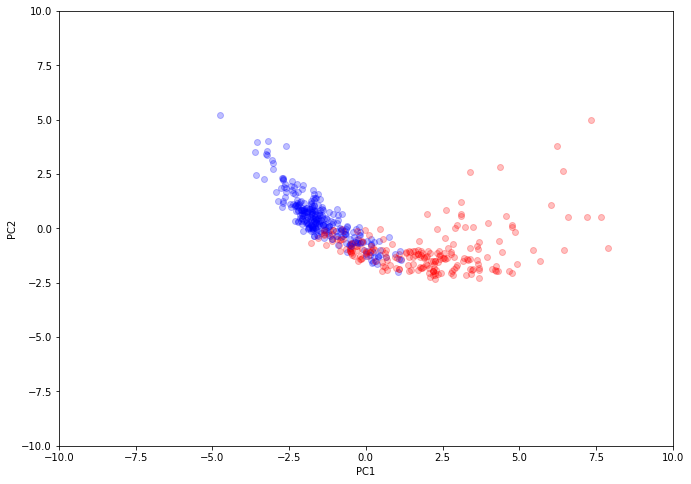

In [18]:
fig , ax1 = plt.subplots(figsize=(11,8))

ax1.set_xlim(-10,10)
ax1.set_ylim(-10,10)

# Plot states names for PC1 and PC2
for i, label in enumerate(url_sample.label.to_list()):
    if i % 10 == 0:
        # plot point
        ax1.scatter(pca_out[i,0], pca_out[i,1], c='b' if label == 1 else 'r', alpha=0.25)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2");

### 3.0 SVD

In [19]:
# Perform SVD
U, s, V = np.linalg.svd(X_scaled, full_matrices=False)

In [20]:
s.shape

(33,)

### 3.0.1 SVD Interpretation on U and V*

1. Since we are performing SVD on the scaled data of the original dataset, it is equivalent to performing PCA on the original dataset
2. The right singular vectors are the principal component axis.
3. The left singular vectors are the principal component scores divided by the singular values.

### 3.1 SVD Principal Components

Text(0.5, 0, 'Principal Component')

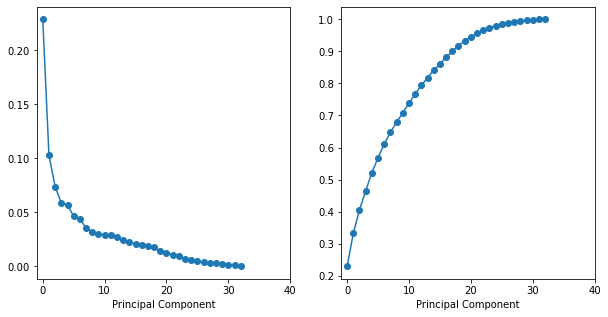

In [21]:
# Find the explained variance
explained_variance_ratio = (s ** 2) / np.sum(s ** 2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot of singular values
ax[0].plot(explained_variance_ratio, marker='o')
ax[0].set_xlim(-1, 40)
ax[0].set_xlabel('Principal Component')
ax[1].plot(np.cumsum(explained_variance_ratio), marker='o')
ax[1].set_xlim(-1, 40)
ax[1].set_xlabel('Principal Component')

We need at approximately 20 principal components to explain 80% of the variance on our dataset.

In [22]:
U.shape

(5000, 33)

What are doing next?

Create a hierarchical cluster (probably using the complete option)
Cut it for 2, 3, and 5 clusters.

### 4.0 Kmeans

### 4.1 Kmeans 2 Clusters

#### 4.1.1 Perform Kmeans

In [23]:
kmeans = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(X_scaled)

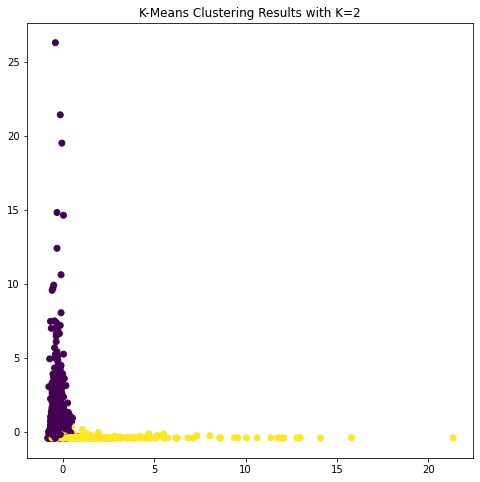

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=2");

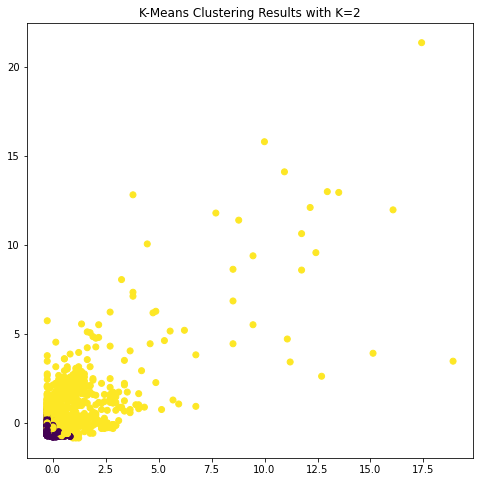

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=2");

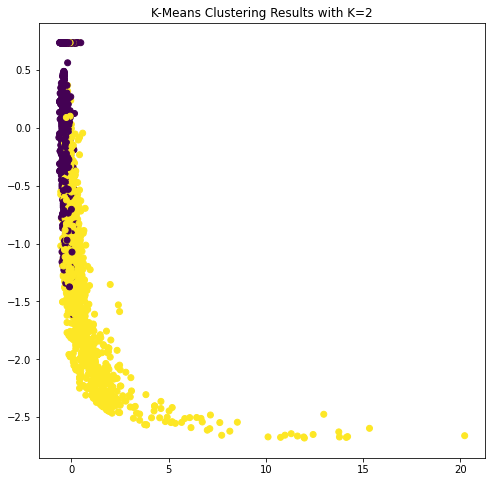

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['URLSimilarityIndex'], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=2");

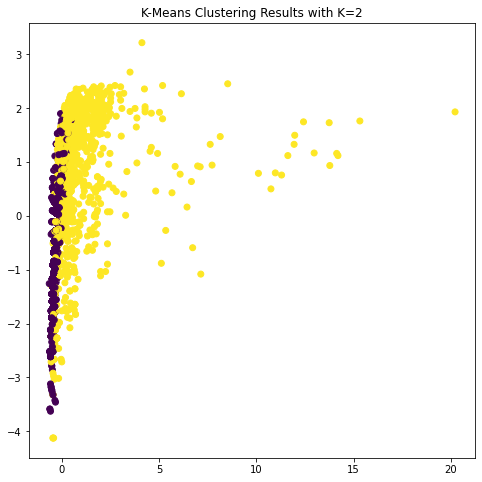

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['LetterRatioInURL'], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=2");

#### 4.1.2 Examine the 2 cluster items

In [28]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(kmeans.labels_ == 0)[0]
one_indexes = np.where(kmeans.labels_ == 1)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)

[3792  568  831   86 2348]
[1447 2824  981 2888 3523]


In [29]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.financedirectory.net.au,34,27,100.000000,0.850000,0.010086,0.063588,2,2,0,0.0,...,0,0,0,0,19,5,11,140,1,141
www.enzteflon.com,27,17,63.143382,1.000000,0.522907,0.055842,3,1,0,0.0,...,1,0,0,0,0,0,1,0,0,0
www.auspop.com.au,24,17,100.000000,0.700000,0.010086,0.063976,2,2,0,0.0,...,0,0,0,2,18,12,28,59,5,61
www.clevelandpolicefoundation.org,40,33,100.000000,1.000000,0.079963,0.062026,3,1,0,0.0,...,0,0,0,2,31,23,42,122,6,128
www.israir.co.il,23,16,100.000000,0.777778,0.001354,0.069597,2,2,0,0.0,...,1,0,0,2,10,3,44,30,101,20


In [30]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
arstmping002.web.app,28,20,49.190476,0.812500,0.001502,0.041671,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
fb-restriction-case-2a201.web.app,42,33,34.327230,0.517241,0.001502,0.050720,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,3
216.172.187.13,21,14,41.777778,0.363636,0.000000,0.001569,2,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
ipfs.io,94,7,9.447791,1.000000,0.012927,0.037762,2,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
dtplkvixf.web.app,26,17,54.191033,0.769231,0.001502,0.034421,3,1,0,0.0,...,1,0,0,0,1,0,0,0,0,1


In [31]:
# First Group, look at the extra columns
X.iloc[group0_random_indexes][['NoOfLettersInURL','LetterRatioInURL','NoOfDegitsInURL','DegitRatioInURL','NoOfEqualsInURL','NoOfQMarkInURL','NoOfAmpersandInURL','NoOfOtherSpecialCharsInURL','SpacialCharRatioInURL','LineOfCode','LargestLineLength','DomainTitleMatchScore','URLTitleMatchScore']]

,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,LineOfCode,LargestLineLength,DomainTitleMatchScore,URLTitleMatchScore
Domain,,,,,,,,,,,,,
www.financedirectory.net.au,20,0.588,0,0.0,0,0,0,2,0.059,681,494,0.0,0.0
www.enzteflon.com,14,0.519,0,0.0,0,0,0,2,0.074,35,126,0.0,100.0
www.auspop.com.au,10,0.417,0,0.0,0,0,0,2,0.083,1412,9381,0.0,0.0
www.clevelandpolicefoundation.org,27,0.675,0,0.0,0,0,0,1,0.025,2431,9381,100.0,100.0
www.israir.co.il,9,0.391,0,0.0,0,0,0,2,0.087,18419,6389,0.0,0.0


In [32]:
# First Group, look at the extra columns
X.iloc[group1_random_indexes][['NoOfLettersInURL','LetterRatioInURL','NoOfDegitsInURL','DegitRatioInURL','NoOfEqualsInURL','NoOfQMarkInURL','NoOfAmpersandInURL','NoOfOtherSpecialCharsInURL','SpacialCharRatioInURL','LineOfCode','LargestLineLength','DomainTitleMatchScore','URLTitleMatchScore']]

,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,LineOfCode,LargestLineLength,DomainTitleMatchScore,URLTitleMatchScore
Domain,,,,,,,,,,,,,
arstmping002.web.app,15,0.536,3,0.107,0,0,0,3,0.107,2,37,6.25,6.25
fb-restriction-case-2a201.web.app,24,0.571,4,0.095,0,0,0,6,0.143,108,8125,0.00,0.00
216.172.187.13,0,0.000,11,0.524,0,0,0,3,0.143,2,28,0.00,0.00
ipfs.io,72,0.766,9,0.096,0,0,0,5,0.053,9,102,0.00,0.00
dtplkvixf.web.app,15,0.577,0,0.000,0,0,0,3,0.115,36,249,0.00,0.00


We looking at the 2 clusters, two differences stand out.  First is that URLSimilarityIndex is usually higher or 100 for almost all URLs in the first cluster.  Second, the number of JavaScript files, CSS files, images, and referrences to other web pages are much larger, or non-zero in the first cluster.  In cluster 2, the URLSimilarityIndex is lower, for the URLs we randomly selected.  Also, the number of JavaScript files, CSS files, images, and referrences to other pages is usually 0.

We can see the legitimate label for the two clusters also appears to match. The second cluster is legitimate websites and the first cluster all has the label field as 0, which means they are phishing websites.

#### 4.1.3 Compare Kmean Results to the Actual Grouping

In [33]:
def getAccuracy(cfMatrix):
    accuracy = (cfMatrix[0][0]+cfMatrix[1][1])/(cfMatrix[0][0]+cfMatrix[0][1]+cfMatrix[1][0]+cfMatrix[1][1])
    return accuracy

In [34]:
# flip the label from 0 to 1, to get the correct sign
url_sample_data['label'] = 1-url_sample_data['label']

# create confusion matrix
confusion_matrix = pd.crosstab(index=kmeans.labels_, columns=url_sample_data['label'], rownames=[''])
print(confusion_matrix)
acc = getAccuracy(confusion_matrix)
print("Kmeans 2 cluster Accuracy: {:.2f}%".format(acc*100))

label     0     1
                 
0      2851   633
1        52  1464
Kmeans 2 cluster Accuracy: 86.30%


#### 4.1.4 Kmeans on 20 Principal Components

In [35]:
# Number of principal components
r = 20

singular_vector_space = U[:,0:r]

kmeans2 = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(singular_vector_space)

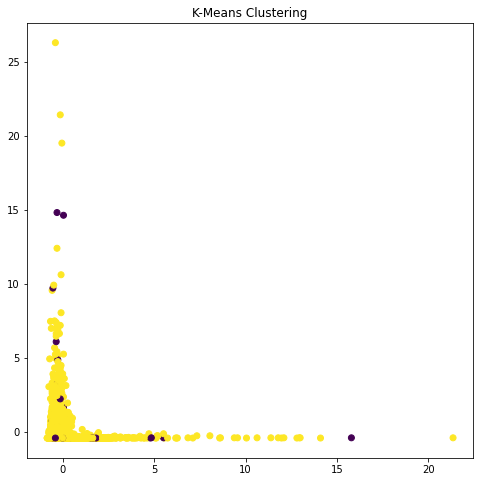

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], c=kmeans2.labels_)
ax.set_title("K-Means Clustering");

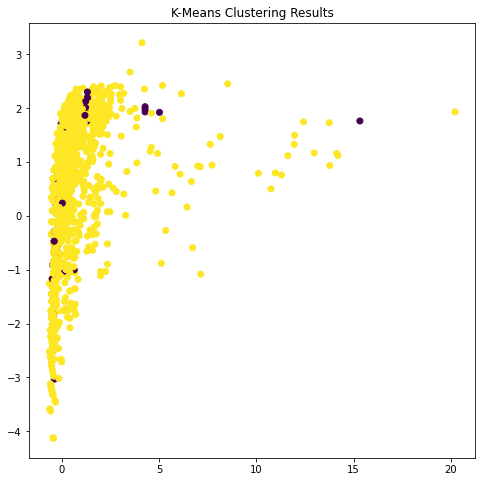

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['LetterRatioInURL'], c=kmeans2.labels_)
ax.set_title("K-Means Clustering Results");

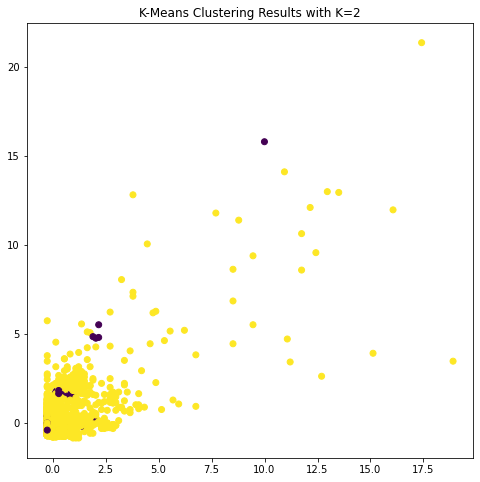

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], c=kmeans2.labels_)
ax.set_title("K-Means Clustering Results with K=2");

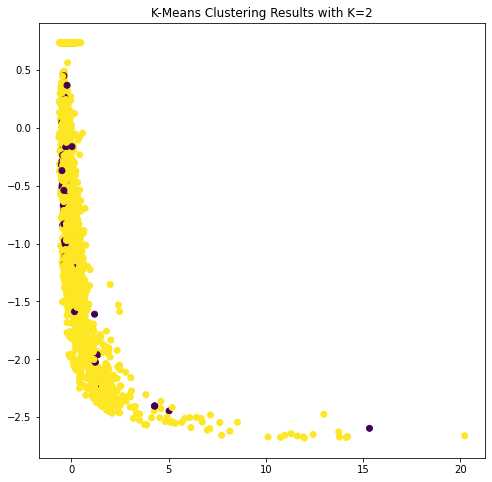

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['URLSimilarityIndex'], c=kmeans2.labels_)
ax.set_title("K-Means Clustering Results with K=2");

In [40]:
# create confusion matrix
confusion_matrix = pd.crosstab(index=kmeans2.labels_, columns=url_sample_data['label'], rownames=[''])
print(confusion_matrix)
acc = getAccuracy(confusion_matrix)
print("Kmeans 2 cluster Accuracy: {:.2f}%".format(acc*100))

label     0     1
                 
0        81   121
1      2822  1976
Kmeans 2 cluster Accuracy: 41.14%


### 4.2 Kmeans 3 clusters

#### 4.2.1 Calculate Kmeans for 3 clusters

In [41]:
kmeans3 = KMeans(n_clusters=3,
                random_state=2,
                n_init=20).fit(X_scaled)

#### 4.2.2 Plot the 3 clusters on some variables

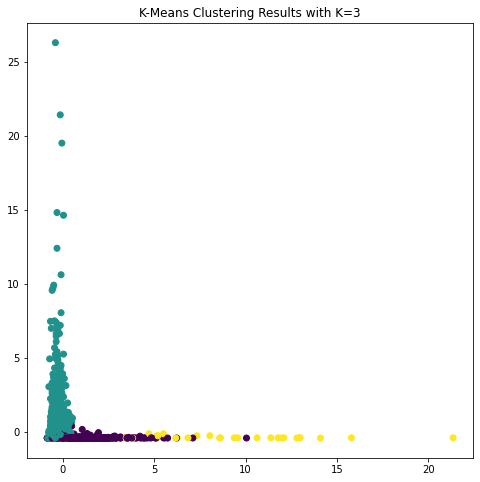

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], c=kmeans3.labels_)
ax.set_title("K-Means Clustering Results with K=3");

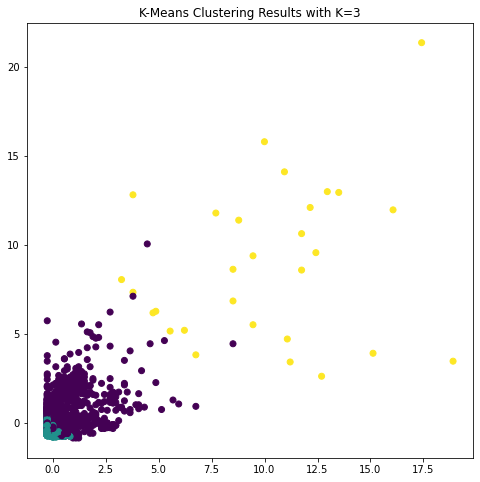

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], c=kmeans3.labels_)
ax.set_title("K-Means Clustering Results with K=3");

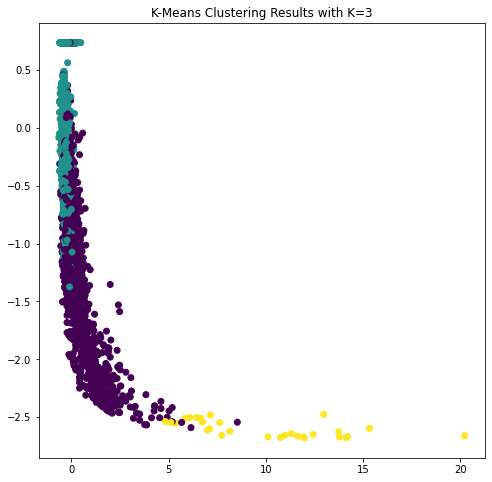

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['URLSimilarityIndex'], c=kmeans3.labels_)
ax.set_title("K-Means Clustering Results with K=3");

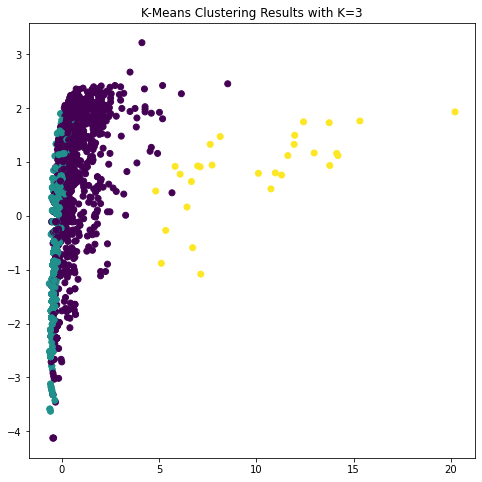

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['LetterRatioInURL'], c=kmeans3.labels_)
ax.set_title("K-Means Clustering Results with K=3");

#### 4.2.3 Examine differences between the 3 groups

In [46]:
# Get examples of URLs from the three different clusters
zero_indexes = np.where(kmeans3.labels_ == 0)[0]
one_indexes = np.where(kmeans3.labels_ == 1)[0]
two_indexes = np.where(kmeans3.labels_ == 2)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
print(group2_random_indexes)

[2853 3867 2139 1632 2798]
[4797 3486 4427 1800  693]
[3470 1612 3896  699 3879]


In [47]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.lvluo.nowurl.fun,26,20,44.898897,0.583333,0.000119,0.045017,3,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
att-105146.weeblysite.com,33,25,66.695385,0.809524,0.522907,0.044085,3,1,0,0.0,...,1,0,0,0,0,0,0,0,0,1
bafybeihckkjsi6zfs6jwbqenmfl2qph72ihyfbj3vxie7mjhfz24mlrbsi.ipfs.dweb.link,94,74,9.467062,0.246377,0.000331,0.033178,4,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
454e4c09-25c9-42d3-a4f5-f4d6b0816cc4.id.repl.co,55,47,32.766347,0.204545,0.005977,0.027171,2,2,0,0.0,...,0,0,0,0,0,0,0,0,0,2
webmail-108950.weeblysite.com,38,29,55.299247,0.680000,0.522907,0.044229,3,1,0,0.0,...,0,0,0,0,19,3,9,1,0,4


In [48]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.koliast.com,21,15,83.471074,1.0,0.522907,0.065769,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
www.nationalgalleries.org,32,25,100.000000,1.0,0.079963,0.066414,3,1,0,0.0,...,0,0,0,2,77,3,13,218,0,34
www.twocatswitchery.com,30,23,100.000000,1.0,0.522907,0.058802,3,1,0,0.0,...,0,0,0,0,28,4,3,35,0,35
www.rauma.fi,19,12,100.000000,1.0,0.002760,0.055580,2,1,0,0.0,...,0,0,0,0,18,3,14,371,1,420
www.kcur.org,19,12,100.000000,1.0,0.079963,0.057876,3,1,0,0.0,...,0,0,0,3,127,1,6,276,0,321


In [49]:
# Third Group
X.iloc[group2_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
allianceinstrumentation.com.sg,256,30,7.309780,0.888889,0.000895,0.018960,2,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
creditrepairr.com,241,17,6.461221,1.000000,0.522907,0.036496,3,0,0,0.0,...,0,0,0,0,19,4,1,0,5,0
creditrepairr.com,234,17,6.691661,1.000000,0.522907,0.031392,3,0,0,0.0,...,0,0,0,0,19,4,1,0,5,0
www.kueronakayaeotn.co.jp.kuerocekayaoato.ppjltg.top,271,52,5.422499,0.363636,0.000275,0.047603,3,5,0,0.0,...,0,0,0,0,10,2,1,0,0,0
attitude.mx,193,11,5.429703,1.000000,0.001722,0.024900,2,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Cluster sizes
print(len(zero_indexes))
print(len(one_indexes))
print(len(two_indexes))

1555
3416
29


### 4.3 Kmeans 5 Cluster

#### 4.3.1 Perform Kmeans with 5 clusters

In [51]:
kmeans5 = KMeans(n_clusters=5,
                random_state=2,
                n_init=20).fit(X_scaled)

#### 4.3.2 Graph the 5 clusters on variables

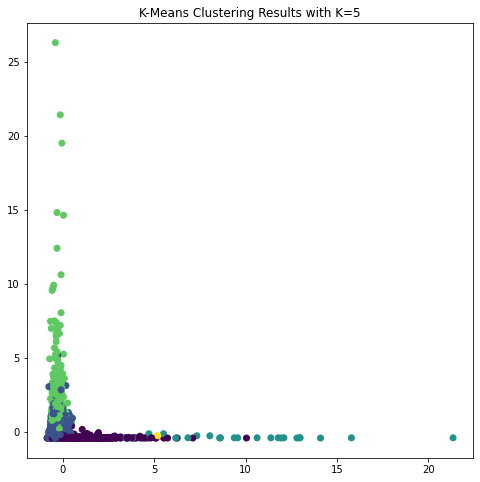

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfLettersInURL'], X_scaled['NoOfImage'], c=kmeans5.labels_)
ax.set_title("K-Means Clustering Results with K=5");

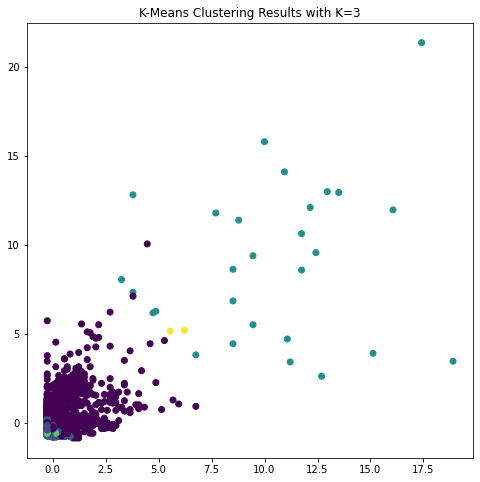

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['NoOfDegitsInURL'], X_scaled['NoOfLettersInURL'], c=kmeans5.labels_)
ax.set_title("K-Means Clustering Results with K=3");

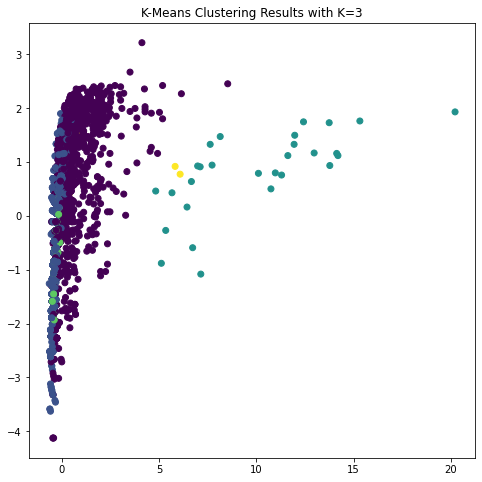

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['LetterRatioInURL'], c=kmeans5.labels_)
ax.set_title("K-Means Clustering Results with K=3");

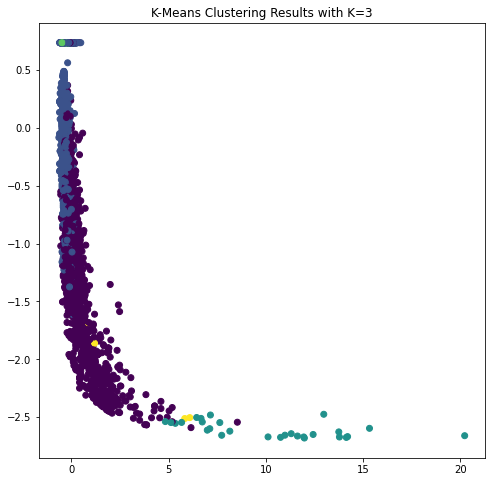

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_scaled['URLLength'], X_scaled['URLSimilarityIndex'], c=kmeans5.labels_)
ax.set_title("K-Means Clustering Results with K=3");

In [56]:
# Get examples of URLs from the three different clusters
zero_indexes = np.where(kmeans5.labels_ == 0)[0]
one_indexes = np.where(kmeans5.labels_ == 1)[0]
two_indexes = np.where(kmeans5.labels_ == 2)[0]
three_indexes = np.where(kmeans5.labels_ == 3)[0]
four_indexes = np.where(kmeans5.labels_ == 4)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
print(group0_random_indexes)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)
print(group1_random_indexes)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
print(group2_random_indexes)
group3_random_indexes = np.random.choice(three_indexes, size=5, replace=False)
print(group3_random_indexes)
group4_random_indexes = np.random.choice(four_indexes, size=2, replace=False)
print(group4_random_indexes)

[4325 1889 4888 3034 3090]
[3163 1271  670 4748 1235]
[1631 3896 4019 4743 1497]
[1655 1814 3477 1051 2896]
[3055 2166]


In [57]:
# Cluster sizes
print(len(zero_indexes))
print(len(one_indexes))
print(len(two_indexes))
print(len(three_indexes))
print(len(four_indexes))

1508
3075
28
383
6


### 5.0 Hierarchical Clustering


In [67]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 5000 records
url_sample = phishingurl_data.sample(60, random_state=13)

# Set index equal to the domain field
url_sample.set_index('Domain', inplace=True)

# Drop text fields: Filename, URL, TLD, Title
url_sample_data = url_sample.drop(['FILENAME', 'URL', 'TLD', 'Title'],axis = 1)

In [68]:
# Drop true / false values
X = url_sample_data.drop(['HasObfuscation', 
                          'IsHTTPS',
                          'IsDomainIP', 
                          'HasTitle',
                          'HasFavicon', 
                          'Robots',
                          'IsResponsive',
                          'HasDescription',
                          'HasExternalFormSubmit', 
                          'HasSocialNet', 
                          'HasSubmitButton', 
                          'HasHiddenFields', 
                          'HasPasswordField', 
                          'Bank',
                          'Pay',
                          'Crypto',
                          'HasCopyrightInfo',
                          'label'],axis = 1)

# Scale the dataset
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

### 5.1 Hierarchical  clustering 2 Clusters

### 5.1.1 Complete linkage clustering

In [69]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(X_scaled)


AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

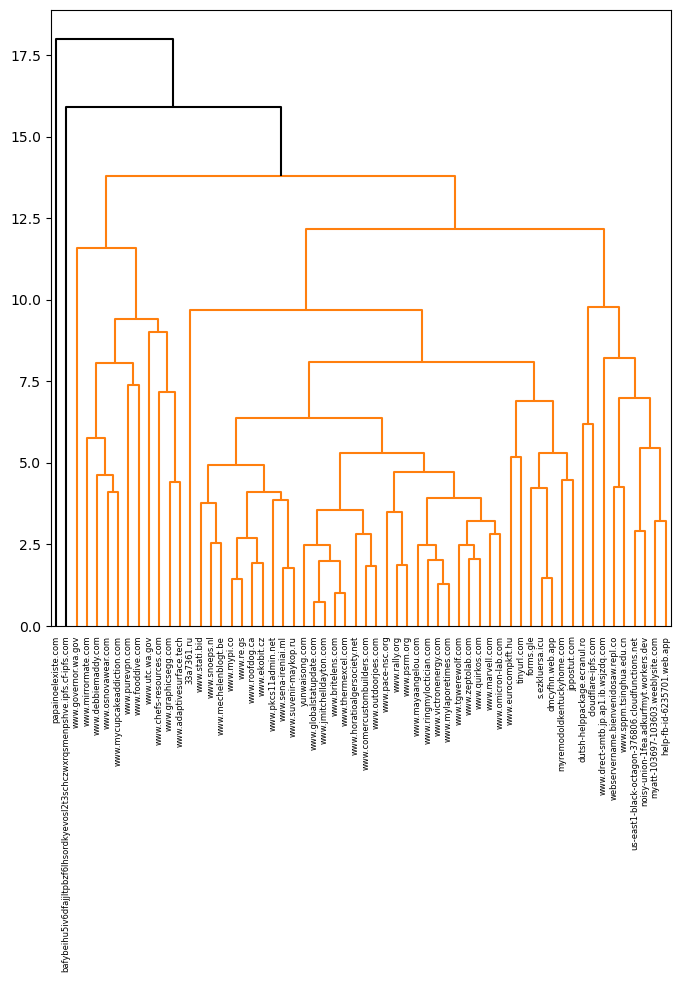

In [70]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=15,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.2 Average linkage clustering

In [71]:
hc_avg = HClust(distance_threshold=0,
                n_clusters=None,
                linkage='average');
hc_avg.fit(X_scaled)

AgglomerativeClustering(distance_threshold=0, linkage='average',
                        n_clusters=None)

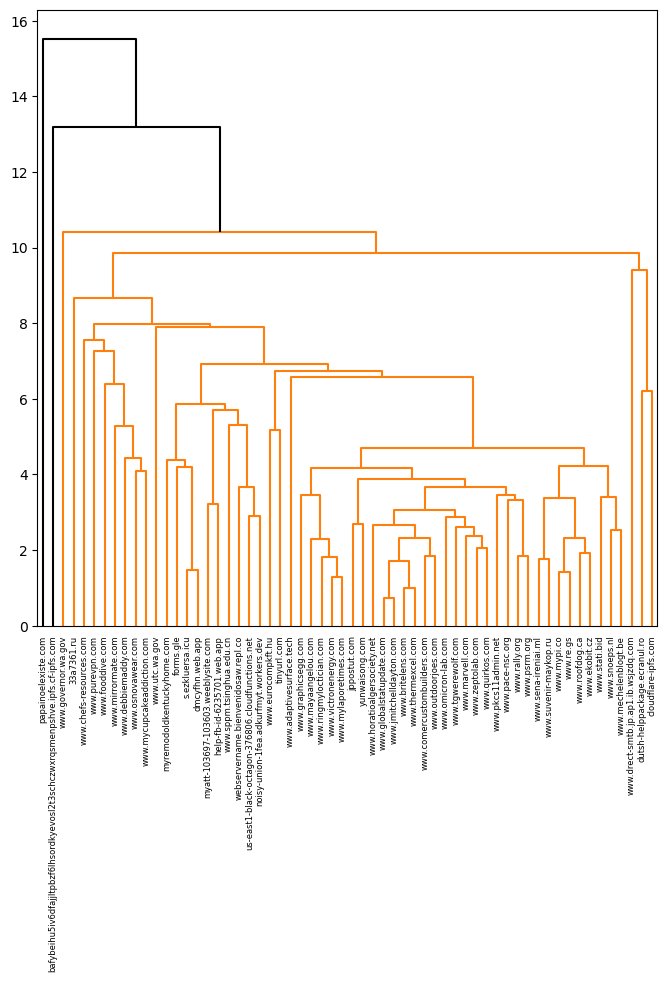

In [72]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_avg)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=12,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.3 Single linkage clustering

In [73]:
hc_sing = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='single');
hc_sing.fit(X_scaled);


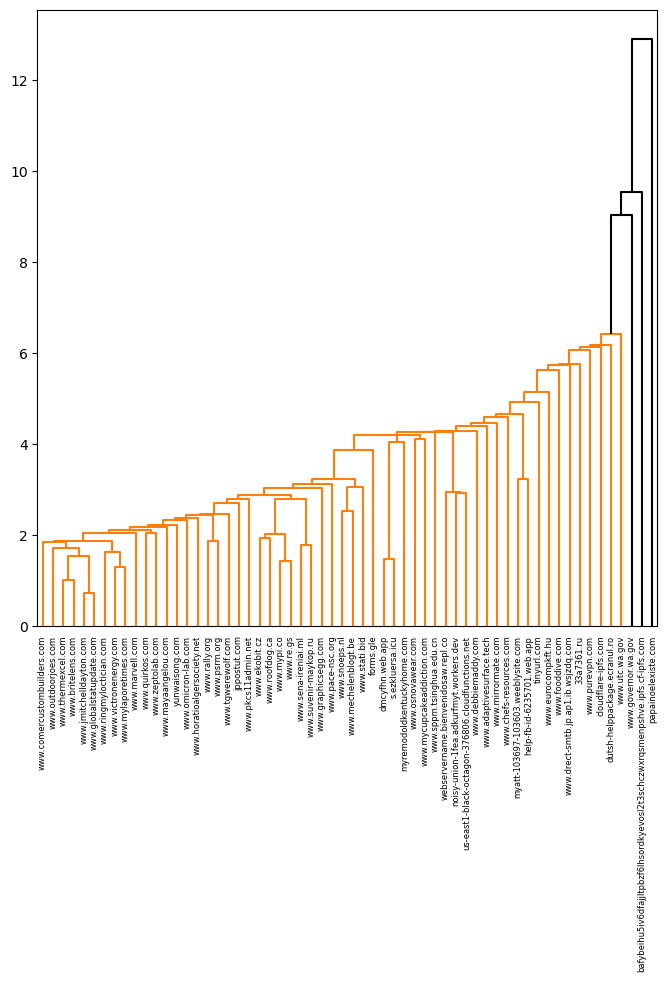

In [74]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_sing)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=8,
           above_threshold_color='black',labels=X.index.tolist());


### 5.1.4 Ward linkage clustering

In [75]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

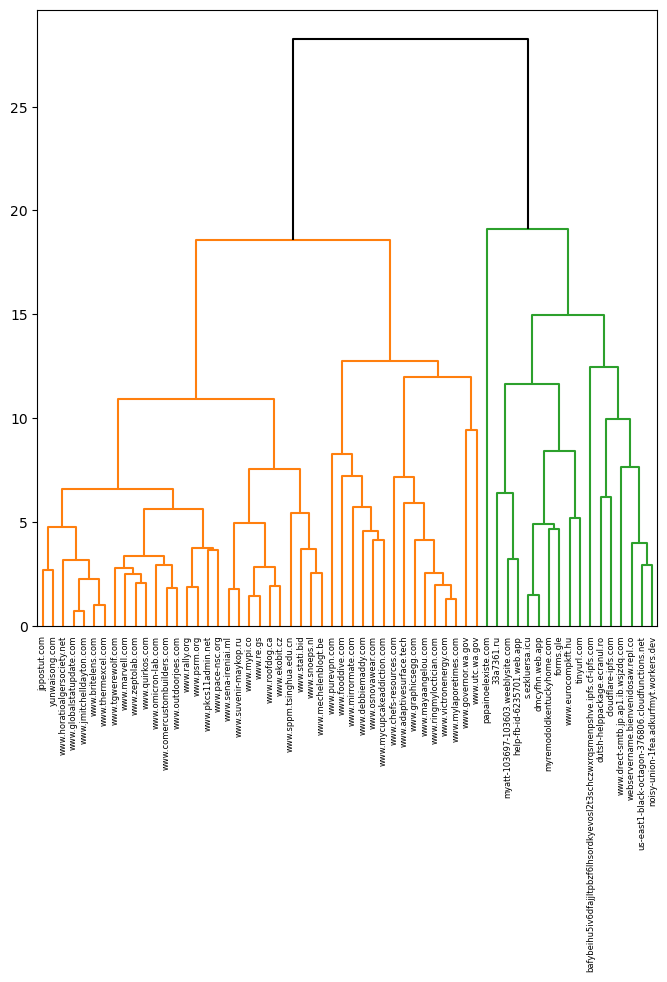

In [76]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=20,
           above_threshold_color='black',labels=X.index.tolist());


In [77]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

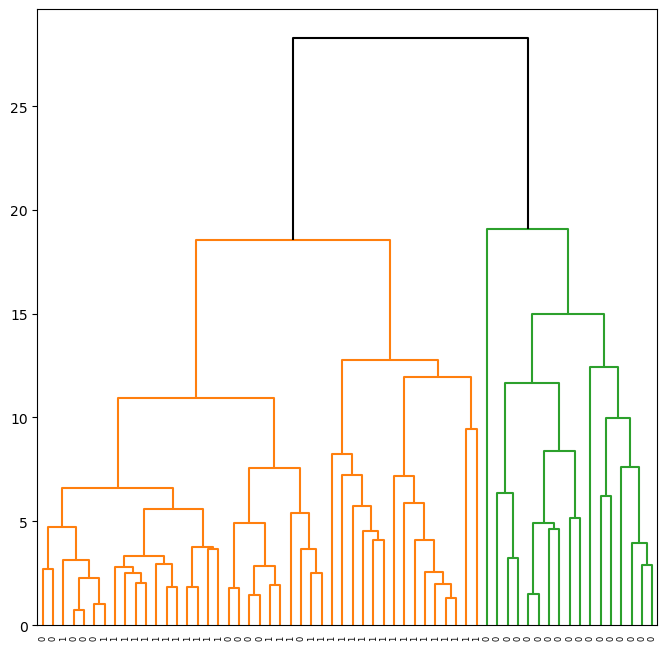

In [78]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=20,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [79]:
clusters_hc = cut_tree(linkage_comp, n_clusters=2).flatten()

In [80]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=5, replace=False)


In [81]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.governor.wa.gov,26,19,100.000000,0.818182,0.003328,0.061525,3,2,0,0.0,...,0,0,1,0,25,21,15,196,1,84
www.snoeps.nl,20,13,100.000000,1.000000,0.008200,0.063324,2,1,0,0.0,...,0,0,0,2,14,5,12,19,2,22
www.chefs-resources.com,30,23,100.000000,0.666667,0.522907,0.065836,3,1,0,0.0,...,0,0,0,3,18,14,32,152,16,143
www.mypi.co,17,11,85.714286,1.000000,0.005977,0.047270,2,1,0,0.0,...,0,0,0,0,1,1,2,0,0,5
www.omicron-lab.com,26,19,100.000000,0.727273,0.522907,0.070389,3,1,0,0.0,...,0,0,0,0,13,8,23,90,2,14


In [82]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
s.ezkluersa.icu,29,15,33.057851,0.909091,0.000040,0.045704,3,1,0,0.0,...,1,0,0,0,0,0,1,0,0,0
bafybeihu5iv6dfajjltpbzf6lhsordkyevosl2t3schczwxrqsmenpshve.ipfs.cf-ipfs.com,94,76,9.412979,0.277778,0.522907,0.040401,3,2,0,0.0,...,0,0,0,0,0,0,0,0,0,0
33a7361.ru,24,10,38.786765,0.714286,0.018013,0.017637,2,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
dutsh-helppackage.ecranul.ro,76,28,15.013038,0.480000,0.001523,0.040328,2,1,0,0.0,...,1,1,0,0,0,0,0,1,0,1
myremodoldkentuckyhome.com,44,26,31.177010,1.000000,0.522907,0.057278,3,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0


### 5.2 Hierarchical  clustering 3 Clusters

In [83]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

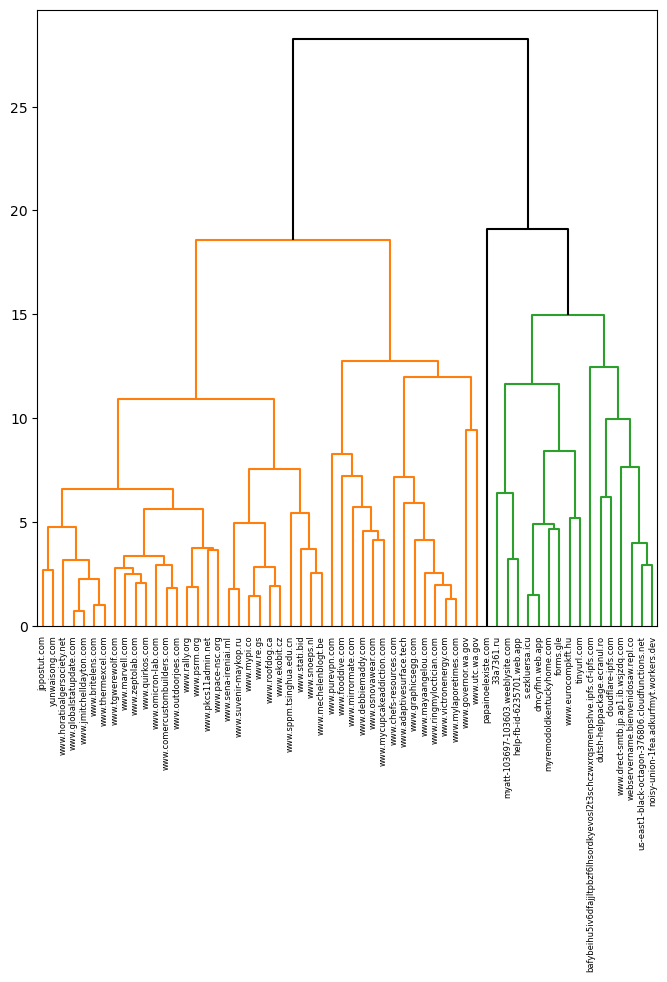

In [84]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=19,
           above_threshold_color='black',labels=X.index.tolist());


In [85]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

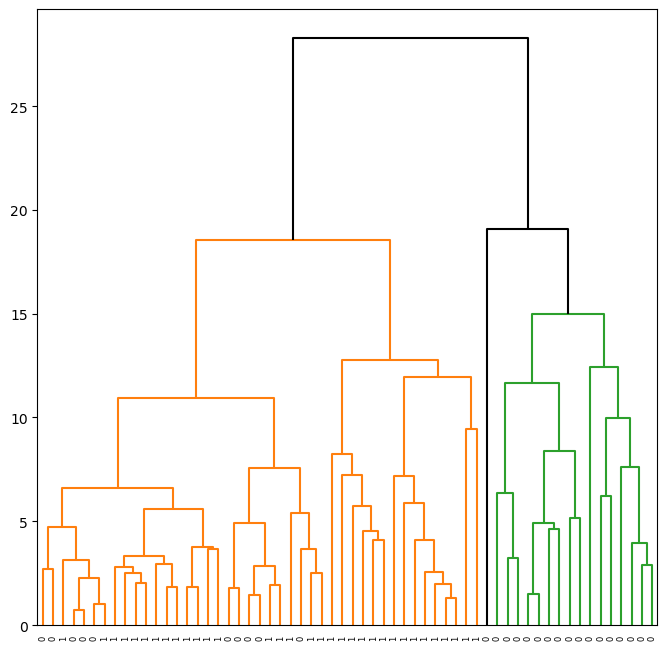

In [86]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=19,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [87]:
clusters_hc = cut_tree(linkage_comp, n_clusters=3).flatten()
clusters_hc

array([0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2])

In [88]:
np.where(clusters_hc == 1)[0]

array([4], dtype=int64)

In [89]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]
two_indexes = np.where(clusters_hc == 2)[0]
group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=1, replace=False)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)

In [90]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.ringmyloctician.com,30,23,100.000000,1.0,0.522907,0.063136,3,1,0,0.0,...,0,0,0,0,31,10,14,46,0,54
www.fooddive.com,23,16,100.000000,1.0,0.522907,0.061877,3,1,0,0.0,...,0,0,0,6,161,3,35,153,1,29
yunwaisong.com,23,14,78.095238,1.0,0.522907,0.056880,3,0,0,0.0,...,0,0,0,0,0,0,0,0,1,1
www.thermexcel.com,25,18,100.000000,1.0,0.522907,0.063827,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,1
www.snoeps.nl,20,13,100.000000,1.0,0.008200,0.063324,2,1,0,0.0,...,0,0,0,2,14,5,12,19,2,22


In [91]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
papainoelexiste.com,87,19,15.266204,1.0,0.522907,0.03075,3,0,0,0.0,...,0,0,0,0,1,1,0,1,0,1


In [92]:
X.iloc[group2_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
cloudflare-ipfs.com,108,19,19.304752,0.733333,0.522907,0.042332,3,0,0,0.0,...,1,0,0,2,1,1,6,0,0,1
tinyurl.com,41,11,40.236590,1.000000,0.522907,0.060734,3,0,0,0.0,...,1,1,0,0,0,0,0,1,0,1
help-fb-id-6235701.web.app,35,26,37.869822,0.545455,0.001502,0.027435,3,1,0,0.0,...,0,0,0,0,0,1,1,1,0,1
myremodoldkentuckyhome.com,44,26,31.177010,1.000000,0.522907,0.057278,3,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
www.eurocompkft.hu,24,18,72.789116,1.000000,0.002217,0.054784,2,1,0,0.0,...,1,1,0,0,0,0,1,0,0,0


### 5.3 Hierarchical  clustering 5 Clusters

In [93]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

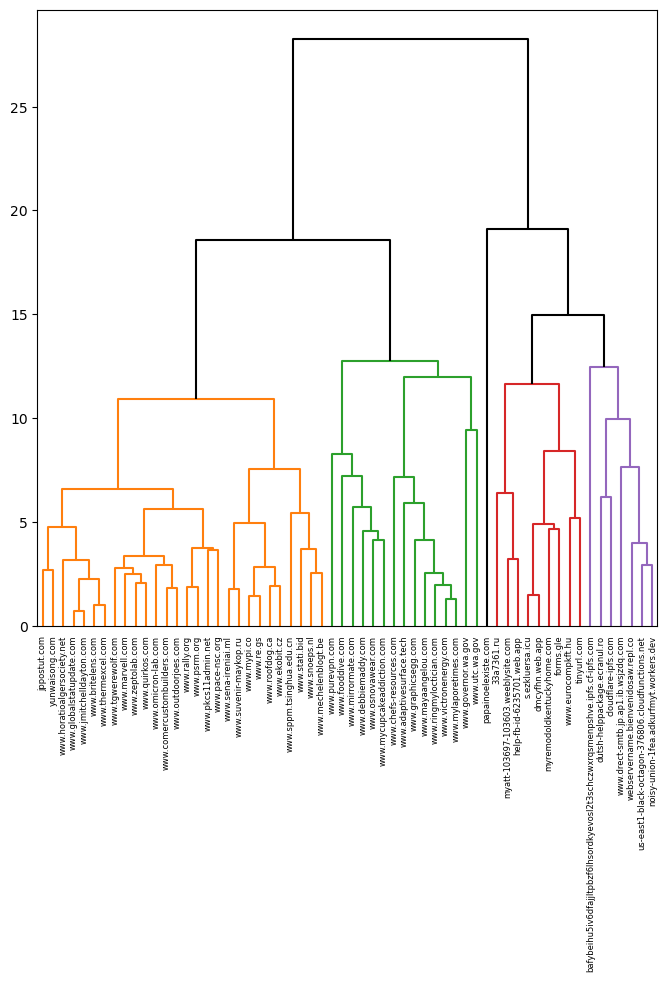

In [94]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=14,
           above_threshold_color='black',labels=X.index.tolist());


In [95]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

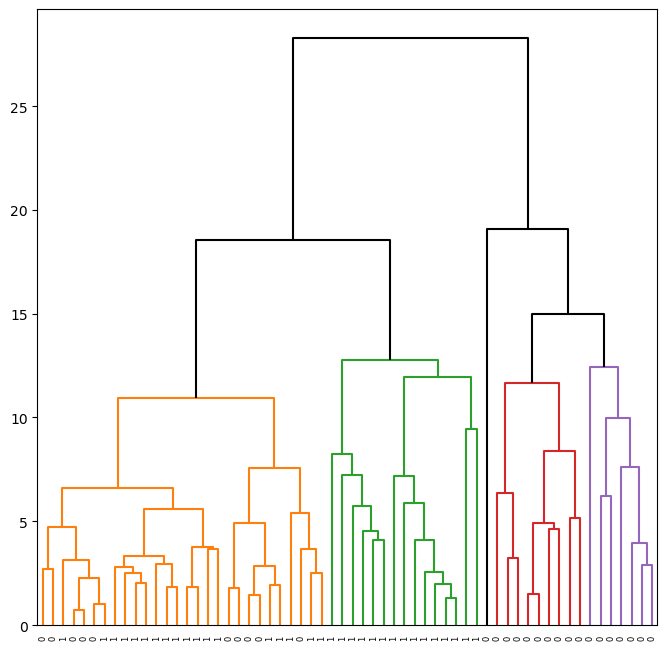

In [96]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=14,
           above_threshold_color='black',labels=url_sample_data.label.tolist());


In [97]:
clusters_hc = cut_tree(linkage_comp, n_clusters=5).flatten()

In [98]:
clusters_hc

array([0, 0, 0, 0, 1, 2, 3, 0, 2, 4, 0, 0, 4, 2, 4, 0, 0, 4, 0, 0, 4, 0,
       4, 0, 0, 4, 3, 4, 0, 0, 0, 0, 2, 2, 4, 0, 0, 2, 4, 2, 0, 4, 3, 3,
       4, 3, 0, 0, 4, 0, 4, 0, 3, 0, 4, 0, 2, 0, 3, 2])

In [99]:
# Get examples of URLs from the two different clusters
zero_indexes = np.where(clusters_hc == 0)[0]
one_indexes = np.where(clusters_hc == 1)[0]
two_indexes = np.where(clusters_hc == 2)[0]
three_indexes = np.where(clusters_hc == 3)[0]
four_indexes = np.where(clusters_hc == 4)[0]

group0_random_indexes = np.random.choice(zero_indexes, size=5, replace=False)
group1_random_indexes = np.random.choice(one_indexes, size=1, replace=False)
group2_random_indexes = np.random.choice(two_indexes, size=5, replace=False)
group3_random_indexes = np.random.choice(three_indexes, size=5, replace=False)
group4_random_indexes = np.random.choice(four_indexes, size=5, replace=False)


In [100]:
# First Group
X.iloc[group0_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.ekobit.cz,20,13,100.000000,1.0,0.003631,0.060266,2,1,0,0.0,...,0,0,0,2,41,2,14,23,2,17
www.tgwerewolf.com,25,18,100.000000,1.0,0.522907,0.056790,3,1,0,0.0,...,0,0,0,0,5,12,3,10,5,11
yunwaisong.com,23,14,78.095238,1.0,0.522907,0.056880,3,0,0,0.0,...,0,0,0,0,0,0,0,0,1,1
www.psrm.org,19,12,100.000000,1.0,0.079963,0.061481,3,1,0,0.0,...,0,0,0,0,14,3,7,56,7,60
www.snoeps.nl,20,13,100.000000,1.0,0.008200,0.063324,2,1,0,0.0,...,0,0,0,2,14,5,12,19,2,22


In [101]:
# Second Group
X.iloc[group1_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
papainoelexiste.com,87,19,15.266204,1.0,0.522907,0.03075,3,0,0,0.0,...,0,0,0,0,1,1,0,1,0,1


In [102]:
X.iloc[group2_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
myatt-103697-103603.weeblysite.com,43,34,31.982205,0.566667,5.229071e-01,0.035070,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,1
forms.gle,34,9,36.291913,1.000000,5.000000e-07,0.034728,3,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
tinyurl.com,41,11,40.236590,1.000000,5.229071e-01,0.060734,3,0,0,0.0,...,1,1,0,0,0,0,0,1,0,1
s.ezkluersa.icu,29,15,33.057851,0.909091,3.980000e-05,0.045704,3,1,0,0.0,...,1,0,0,0,0,0,1,0,0,0
33a7361.ru,24,10,38.786765,0.714286,1.801320e-02,0.017637,2,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
X.iloc[group3_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
dutsh-helppackage.ecranul.ro,76,28,15.013038,0.480000,0.001523,0.040328,2,1,0,0.0,...,1,1,0,0,0,0,0,1,0,1
www.drect-smtb.jp.ap1.ib.wsjzdq.com,67,35,18.479339,0.296296,0.522907,0.044917,3,5,0,0.0,...,0,0,0,0,0,0,0,0,0,0
cloudflare-ipfs.com,108,19,19.304752,0.733333,0.522907,0.042332,3,0,0,0.0,...,1,0,0,2,1,1,6,0,0,1
us-east1-black-octagon-376806.cloudfunctions.net,64,48,43.487603,0.477273,0.038420,0.051228,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
webservername.bienvenidosaw.repl.co,44,35,34.448980,0.437500,0.005977,0.059786,2,2,0,0.0,...,0,0,0,0,0,0,0,0,0,2


In [104]:
X.iloc[group4_random_indexes]

,URLLength,DomainLength,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,NoOfObfuscatedChar,ObfuscationRatio,...,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef
Domain,,,,,,,,,,,,,,,,,,,,,
www.governor.wa.gov,26,19,100.0,0.818182,0.003328,0.061525,3,2,0,0.0,...,0,0,1,0,25,21,15,196,1,84
www.adaptivesurface.tech,31,24,100.0,1.000000,0.000505,0.059033,4,1,0,0.0,...,0,0,0,0,14,26,41,60,0,66
www.utc.wa.gov,21,14,100.0,0.666667,0.003328,0.054683,3,2,0,0.0,...,0,0,0,2,17,5,9,507,5,25
www.chefs-resources.com,30,23,100.0,0.666667,0.522907,0.065836,3,1,0,0.0,...,0,0,0,3,18,14,32,152,16,143
www.mayaangelou.com,26,19,100.0,1.000000,0.522907,0.065196,3,1,0,0.0,...,0,0,0,3,62,13,27,38,1,85


### 5.4 Hierarchical  clustering 2 Clusters, computation of confusion matrix

In [105]:
hc_ward = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward');
hc_ward.fit(X_scaled);

In [106]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_ward)



In [107]:
clusters_hc = cut_tree(linkage_comp, n_clusters=2).flatten()
clusters_hc

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1])

In [108]:
url_sample_data['label'].unique()

array([1, 0], dtype=int64)

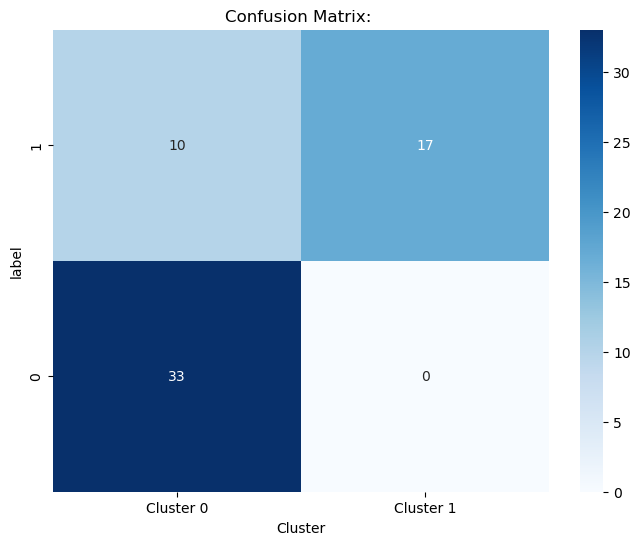

In [109]:
# Create a confusion matrix
conf_matrix = confusion_matrix(url_sample_data['label'], clusters_hc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0', 'Cluster 1'], yticklabels=['1','0'])
plt.xlabel('Cluster')
plt.ylabel('label')
plt.title('Confusion Matrix: ')
plt.show()